# Importing the libraries

In [1]:
### Extracting the dataset from the .zip file
from os import walk
import zipfile

### Work with the dataset
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Setting default values

Setting some default values to be used all over the code.

In [70]:
### Used to fill the random state of some functions
SEED = 50

### The number of samples to be used during the machine learning model training
N_SAMPLES = 10**4

# Extracting and loading the dataset

In [3]:
### Find the .zip file and get the path to extract it
dataset_folder = './dataset'
    
filenames = next(walk(dataset_folder), (_, _, []))[2]
zip_filename = [filename for filename in filenames if filename.find('.zip') > -1][0]
file_path = dataset_folder + '/' + zip_filename

You only need to run the code cell below if you put solely the .zip file insede the dataset folder.

In [4]:
### Extracting the contents of the .zip file inside the dataset folder
# with zipfile.ZipFile(file_path, 'r') as zip_ref:
#     zip_ref.extractall(dataset_folder)

In [5]:
### Get the .txt dataset file path extracted at the previous step
filenames = next(walk(dataset_folder), (_, _, []))[2]
dataset_filename = [filename for filename in filenames if filename.find('.txt') > -1][0]
dataset_path = dataset_folder + '/' + dataset_filename

To load the dataset inside a Pandas DataFrame we had to put the delimiter to be a TAB (\t) because it is how the data is separated inside the .txt file.

In [6]:
df = pd.read_csv(dataset_path, delimiter = "\t")

# Analyzing the dataset

In [7]:
df.shape

(1451003, 57)

In [8]:
df.head()

,Row,Sample Name,Transaction Id,Anon Student Id,Session Id,Time,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,...,KC (MCAS5-State_WPI-Simple),KC Category (MCAS5-State_WPI-Simple),KC (MCAS5-State_WPI-Simple).1,KC Category (MCAS5-State_WPI-Simple).1,KC (Single-KC),KC Category (Single-KC),KC (Unique-step),KC Category (Unique-step),School,Class
0,1,All Data,13cb29890fa2be0ca31bcd07f35000d6,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:10,US/Eastern,22,ATTEMPT,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
1,2,All Data,3fedf6c06ab6b9b3c36e245335445bcf,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:13,US/Eastern,3,HINT_REQUEST,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
2,3,All Data,0f5bb1a5c133ac1aa0a3d32e4d44dde9,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:20,US/Eastern,7,HINT_REQUEST,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
3,4,All Data,19a9aabf614d6f27dc9970dc842da081,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:22,US/Eastern,2,HINT_REQUEST,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
4,5,All Data,eae2bd81fd19ec6093c645d90e92222e,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:32,US/Eastern,10,ATTEMPT,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy


In [9]:
df.dtypes

Row                                          int64
Sample Name                                 object
Transaction Id                              object
Anon Student Id                             object
Session Id                                   int64
Time                                        object
Time Zone                                   object
Duration (sec)                              object
Student Response Type                       object
Student Response Subtype                   float64
Tutor Response Type                         object
Tutor Response Subtype                     float64
Level (Curriculum)                          object
Problem Name                                 int64
Problem View                               float64
Problem Start Time                          object
Step Name                                   object
Attempt At Step                            float64
Is Last Attempt                            float64
Outcome                        

In [10]:
df.describe()

,Row,Session Id,Student Response Subtype,Tutor Response Subtype,Problem Name,Problem View,Attempt At Step,Is Last Attempt,Help Level,Total Num Hints,...,KC Category (WPI-Apr-2005).4,KC Category (WPI-Apr-2005).5,KC Category (MCAS39-State_WPI-Simple),KC Category (MCAS39-State_WPI-Simple).1,KC Category (MCAS39-State_WPI-Simple).2,KC Category (MCAS39-State_WPI-Simple).3,KC Category (MCAS5-State_WPI-Simple),KC Category (MCAS5-State_WPI-Simple).1,KC Category (Single-KC),KC Category (Unique-step)
count,1.451003e+06,1.451003e+06,0.0,0.0,1.451003e+06,1.450822e+06,1.448076e+06,1.448076e+06,394514.000000,303756.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,7.255020e+05,4.409396e+06,NaN,NaN,5.609072e+03,1.281691e+00,2.341389e+00,4.472597e-01,2.010413,3.529932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.188686e+05,2.780981e+06,NaN,NaN,5.119680e+03,6.858265e-01,2.543439e+00,4.972108e-01,1.419201,1.298585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,6.720000e+02,NaN,NaN,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.627515e+05,1.363892e+06,NaN,NaN,1.149000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.255020e+05,5.450824e+06,NaN,NaN,3.133000e+03,1.000000e+00,1.000000e+00,0.000000e+00,2.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.088252e+06,6.838668e+06,NaN,NaN,9.562000e+03,1.000000e+00,3.000000e+00,1.000000e+00,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.451003e+06,8.167924e+06,NaN,NaN,1.865100e+04,2.400000e+01,1.200000e+02,1.000000e+00,57.000000,47.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.nunique()

Row                                        1451003
Sample Name                                      1
Transaction Id                             1451003
Anon Student Id                               5046
Session Id                                  392886
Time                                       1027591
Time Zone                                        1
Duration (sec)                                 641
Student Response Type                            2
Student Response Subtype                         0
Tutor Response Type                              2
Tutor Response Subtype                           0
Level (Curriculum)                               1
Problem Name                                  1798
Problem View                                    17
Problem Start Time                          347840
Step Name                                     5834
Attempt At Step                                120
Is Last Attempt                                  2
Outcome                        

Each row of the dataset represents an interaction an user has with an intelligent tutoring system.

The students are divided between schools and classes.

As we can see there are some columns that probably will not be very useful for most of the analysis.

Some columns contains no unique values, so they are candidate to be dropped. Other ones have an exclusive value per row, not contributing with the analysis.

# Data preprocessing

The criteria used to drop the columns were:
- Columns with one or less unique values in it.
- Columns with all rows with unique values.
- KC columns (KCs are Knowledge Components, created using the system provided by DataShop system, where we got the data).
- Columns with high quantity of unique values (probably they will overfit the machine learning model).

In [12]:
def drop_unnecessary_columns(df):
    """ Drop unnecessary columns from a dataframe to be used during the analysis
    The criteria used to drop the columns are:
        - 1 o less unique values per column;
        - All rows containing unique values;
        - Columns that represent the KC;
        - Columns with a high quantity of unique values.
        
    Arguments:
        - df (pandas DataFrame): The dataframe containing the columns to be dropped.
        
    Returns:
        - df_cleaned (pandas DataFrame): A copy of the input dataframe with the columns dropped.
    """
    
    unique_values = df.nunique()
    
    ### Dropping the columns with 0 or 1 exclusive values
    df_cleaned = df.loc[:, (unique_values > 1)]
    
    ### Dropping the columns with an unique value per row
    df_cleaned = df_cleaned.loc[:, (unique_values < df_cleaned.shape[0])]
    
    ### Dropping the KC columns
    df_cleaned = df_cleaned.loc[:, [col.find('KC (') < 0 for col in df_cleaned.columns]]
    
    ### Dropping columns with high variability values
    ### At this part only the "Time" and "Problem Start Time" were dropped
    ### I will not drop the Session Id column because I want to use it at the Machine Learning code
    columns_to_drop = [k for k,v in df_cleaned.nunique().items() if ((v / df_cleaned.shape[0]) > 0.2) and (k != 'Session Id')]
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)
    
    return df_cleaned

In [13]:
def adjust_data_types(df):
    """ Adjust the data types of columns classified as object or float to float and integer respectively.
        
    Arguments:
        - df (pandas DataFrame): The dataframe containing the columns to be adjusted.
        
    Returns:
        - df_new (pandas DataFrame): A copy of the input dataframe with the columns' types adjusted.
    """
    
    df_new = df.copy()
    
    ### Converting the "Duration (sec)" values from object to float
    ### It had to be converted to float because it has some decimal values at some rows
    ### We had to replace the dot (.) values to convert the values to float
    df_new['Duration (sec)'] = df_new['Duration (sec)'].replace('.', '0', regex=False).astype('float64')

    ### Converting some float columns to int to reduce the range of allowed values in these columns
    ### They don't need to use decimal points for theirs values
    ### I had to use the Int64 type (Pandas integer) instead of int64 type (Numpy integer) because the existent NaN values that could not be converted
    float_to_int_columns = ['Problem View', 'Attempt At Step', 'Is Last Attempt', 'Help Level', 'Total Num Hints']

    df_new[float_to_int_columns] = df_new[float_to_int_columns].astype('Int64')
    
    return df_new

In [14]:
df_cleaned = drop_unnecessary_columns(df)
df_cleaned = adjust_data_types(df_cleaned)

In [15]:
df_cleaned.head()

,Anon Student Id,Session Id,Duration (sec),Student Response Type,Tutor Response Type,Problem Name,Problem View,Step Name,Attempt At Step,Is Last Attempt,Outcome,Selection,Action,Input,Feedback Text,Feedback Classification,Help Level,Total Num Hints,School,Class
0,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,22.0,ATTEMPT,RESULT,10168,1,Step0:10168:There are 100 squares in the 10 by...,1,0,INCORRECT,Step0:10168:There are 100 squares in the 10 by...,1,80/100,Don't forget to reduce your fraction.,NaN,<NA>,<NA>,ForestGrove,Period40607Dumphy
1,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,3.0,HINT_REQUEST,HINT_MSG,10168,1,Step0:10168:There are 100 squares in the 10 by...,2,0,HINT,Step0:10168:There are 100 squares in the 10 by...,1,NaN,There are 100 squares and 80 are colored purple.,HINT,1,<NA>,ForestGrove,Period40607Dumphy
2,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,7.0,HINT_REQUEST,HINT_MSG,10168,1,Step0:10168:There are 100 squares in the 10 by...,3,0,HINT,Step0:10168:There are 100 squares in the 10 by...,1,NaN,80/100 squares are colored purple. Reduce this...,HINT,2,<NA>,ForestGrove,Period40607Dumphy
3,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2.0,HINT_REQUEST,HINT_MSG,10168,1,Step0:10168:There are 100 squares in the 10 by...,4,0,HINT,Step0:10168:There are 100 squares in the 10 by...,1,NaN,80/100 = 8/10 = 4/5,HINT,3,<NA>,ForestGrove,Period40607Dumphy
4,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,10.0,ATTEMPT,RESULT,10168,1,Step0:10168:There are 100 squares in the 10 by...,5,1,CORRECT,Step0:10168:There are 100 squares in the 10 by...,1,4/5,NaN,NaN,<NA>,<NA>,ForestGrove,Period40607Dumphy


## Checking the differences between some columns

Some columns apparently have similar values or similar information.

Below we analyzed the differences between the *Step Name* and the *Selection* columns. Apparently they have the same values for each row, so it would be wiser to drop one of them. The only difference we found between then is that the *Step Name* column has aditional text at the end of it, probably because some misconfiguration of the input dataset.

The other ones that have similar information are the *Help Level* and the *Total Num Hints* columns. But the *Total Num Hints* only stores the maximum value of the *Help Level* grouped by *Session*, *Problem Name* and *Step Name*.

**_Step Name_ and _Selection_ columns**

In [16]:
### Creating a test DataFrame with only the rows that have explicitly different values on which column
df_test_step_selection = df_cleaned[df_cleaned['Step Name'] != df_cleaned['Selection']][['Step Name', 'Selection']]
df_test_step_selection = df_test_step_selection.reset_index()

In [17]:
idx = 0

print('Values at index {} without reduncing the length of the "Step Name" column.'.format(idx))
print(df_test_step_selection['Step Name'][idx])
print(df_test_step_selection['Selection'][idx])

selection_len = len(df_test_step_selection['Selection'][idx])

print()
print('Values at index {} reduncing the length of the "Step Name" column.'.format(idx))
print(df_test_step_selection['Step Name'][idx][:selection_len])
print(df_test_step_selection['Selection'][idx])

Values at index 0 without reduncing the length of the "Step Name" column.
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction) 1
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction)

Values at index 0 reduncing the length of the "Step Name" column.
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction)
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction)


In [18]:
total_diff = 0
total_nan = 0

for i in range(df_test_step_selection.shape[0]):
    selection_len = len(df_test_step_selection['Selection'][i])
    
    step = df_test_step_selection['Step Name'][i]
    
    if type(step) == str:
        step = step[:selection_len]
    else:
        total_nan += 1
    
    if step != df_test_step_selection['Selection'][i]:
        total_diff += 1

print('Calculated differences between columns when the length of the "Step Name" column is reduced to match the "Selection" column.')
print('Total of different values: {}'.format(total_diff))
print('Total of different values with at leat one NaN: {}'.format(total_nan))
print('Total of different values without the NaNs: {}'.format(total_diff - total_nan))

Calculated differences between columns when the length of the "Step Name" column is reduced to match the "Selection" column.
Total of different values: 4302
Total of different values with at leat one NaN: 2927
Total of different values without the NaNs: 1375


In [19]:
### There are so few values that the differences are not relevant
pct_diff = (total_diff - total_nan) / df_cleaned.shape[0]

print('There is only {:.4f}% of different values between the "Step Name" and the "Selection" columns.'.format(pct_diff))

There is only 0.0009% of different values between the "Step Name" and the "Selection" columns.


In [20]:
df_cleaned = df_cleaned.drop(columns=['Selection'])

**_Help Level_ and _Total Num Hints_ columns**

In [21]:
### Getting only the rows where the "Total Num Hints" column has some value
df_test_hints = df_cleaned[df_cleaned['Total Num Hints'] >= 0]

df_test_hints = df_test_hints[df_test_hints['Total Num Hints'] != df_test_hints['Help Level']]

df_test_hints[['Session Id', 'Problem Name', 'Step Name', 'Outcome', 'Help Level', 'Total Num Hints']].head(10)

,Session Id,Problem Name,Step Name,Outcome,Help Level,Total Num Hints
29,5661544,3738,Step1:3739:What is the difference between the ...,HINT,1,3
30,5661544,3738,Step1:3739:What is the difference between the ...,HINT,2,3
33,5661544,3738,"Step2:3740:Well done. Now, what is the differe...",HINT,1,3
34,5661544,3738,"Step2:3740:Well done. Now, what is the differe...",HINT,2,3
37,5661544,3738,"Step3:3741:Good. So, we see that the salary go...",HINT,1,2
41,5661544,3738,Step4:3742:Good. Now what is the salary of an ...,HINT,1,4
42,5661544,3738,Step4:3742:Good. Now what is the salary of an ...,HINT,2,4
43,5661544,3738,Step4:3742:Good. Now what is the salary of an ...,HINT,3,4
47,5662026,8135,Step1:8136:Every factor has a partner because ...,HINT,1,2
51,5662026,8135,"Step2:8137:130 divided by 2 is 65, so the fact...",HINT,1,6


In [22]:
print('Total of different values between columns: {}'.format(df_test_hints.shape[0]))

Total of different values between columns: 212393


## Enhancing the dataset

At this part we tried to create some new columns to be used during the training of the predictive model.

Columns created:
- Last Help Level: indicating what was the last value of the column *Help Level* before CORRECT or INCORRECT value at the *Outcome* column.

**Last Help Level**

We can get the Last Help Level grouping the *Session Id*, *Problem Name* and *Step Name* columns.

We have to group by these columns because after that, the Help Level returns to the value of 0.

We have to fill the remaing NaN values with 0 because, sometimes the grouping doesn't start with the outcoume of a HINT, causing the Help Value to be a NaN.

In [69]:
### Based on https://stackoverflow.com/questions/44111425/cannot-use-fillna-when-a-condition-is-introduced

### This step could take a while
group_columns = ['Session Id', 'Problem Name', 'Step Name']

### Filling the next value based on the grouping
df_cleaned['Last Help Level'] = df_cleaned.groupby(group_columns)['Help Level'].apply(lambda x: x.fillna(method='ffill'))

### Filling the initial value
df_cleaned['Last Help Level'] = df_cleaned['Last Help Level'].fillna(0)

# Data analysis

In [23]:
def plot_bar(data, title='Number of occurrences', xlabel='x', ylabel='Number of occurrences', rotation=90, show_xticks=True):
    """Plots a bar chart with some customizations
    
    Arguments:
        - data (pandas Series): A series containing the data to plot the chart
        - title (str): The title of the chart
        - xlabel (str): The label of the x axis of the chart
        - ylabel (str): The label of the y axis of the chart
        - rotation (int): The rotation angle of the values of the x axis
        - show_xticks (boolean): Definie if the chart has to show or not the values at xticks
    
    Returns:
        - None: Only plots the bar chart
    """
    x = data.keys()
    y = data.values
    
    plt.figure(figsize=(16, 6))

    plt.bar(x, y);
    
    plt.title(title);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.xticks(rotation=rotation);
    
    if not show_xticks:
        plt.xticks([])
    
    plt.show();

In [24]:
def print_statistics(data):
    """ Print some statistics based on the input data
    
    Arguments:
        - data (pandas Series): A series containing the data to plot the chart
        
    Returns:
        - None: Only print the statistics
    """
    
    print('Number of distinct values: {}'.format(len(data)))
    print('Mean: {:.2f}'.format(data.mean()))
    print('Median: {:.2f}'.format(data.median()))
    print('Standard Deviation: {:.2f}'.format(data.std()))

## Analyzing the number of interactions

**School**

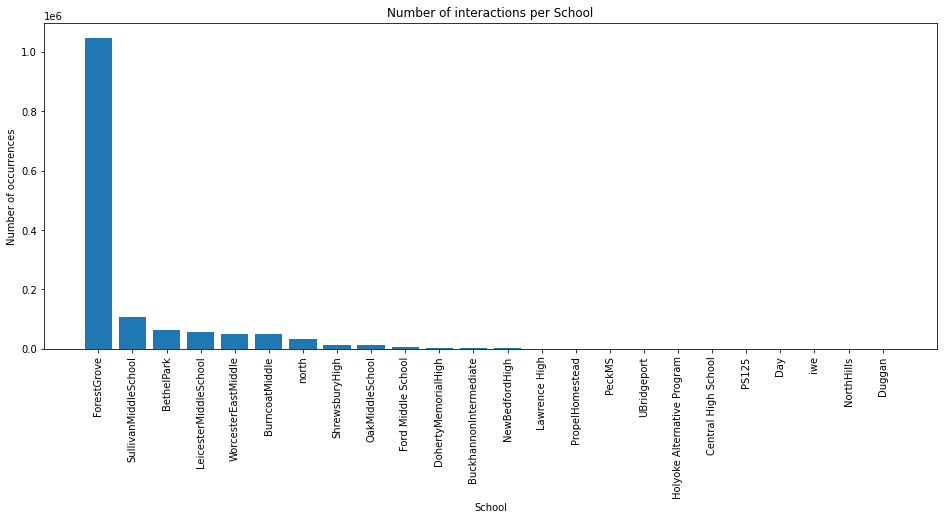

Number of distinct values: 24
Mean: 60397.67
Median: 1732.00
Standard Deviation: 211806.72


In [25]:
column = 'School'
data = df_cleaned[column].value_counts()
plot_bar(data, title='Number of interactions per {}'.format(column), xlabel=column)

print_statistics(data)

**Class**

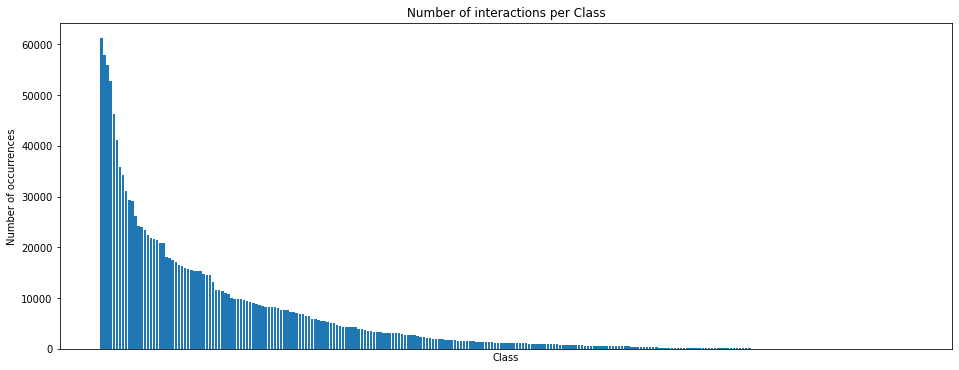

Number of distinct values: 262
Mean: 5528.00
Median: 1176.00
Standard Deviation: 10040.06


In [26]:
column = 'Class'
data = df_cleaned[column].value_counts()

### Hide the xticks because there is a lot of distinct values to show and the importance of this char is to show the distribution not the values by itself
plot_bar(data, title='Number of interactions per {}'.format(column), xlabel=column, show_xticks=False)

print_statistics(data)

**Student**

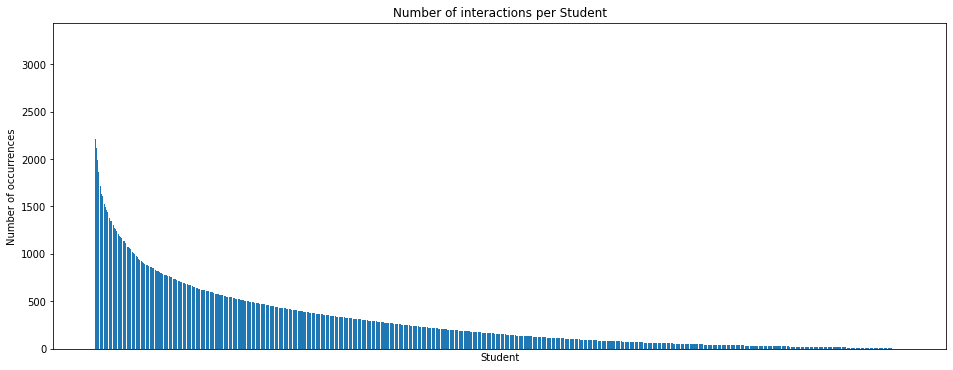

Number of distinct values: 5046
Mean: 287.56
Median: 155.50
Standard Deviation: 349.96


In [27]:
column = 'Student'
data = df_cleaned['Anon ' + column + ' Id'].value_counts()

### Hide the xticks because there is a lot of distinct values to show and the importance of this char is to show the distribution not the values by itself
plot_bar(data, title='Number of interactions per {}'.format(column), xlabel=column, show_xticks=False)

print_statistics(data)

As we can see the number of interactions is not well distribuited, mostly comparing the distribution between schools where the ForestGrove school has a higher number of interactions. This could cause some bias at these analysis.

The interactions divided between classes and students follow the same pattern but with a lower standard deviation on data.

## Analyzing the number of students

**School**

In [48]:
# Based on https://www.kite.com/python/answers/how-to-count-unique-values-in-a-pandas-dataframe-group-in-python
grouped_df = df_cleaned[['Anon Student Id', 'School']].groupby('School')
grouped_df = grouped_df.agg({'Anon Student Id': 'nunique'}).reset_index()

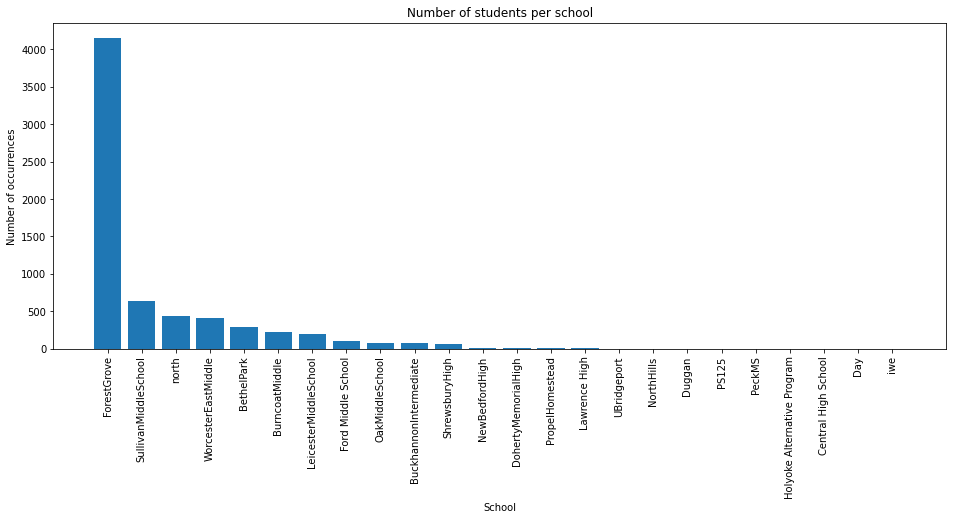

Number of distinct values: 24
Mean: 279.71
Median: 13.50
Standard Deviation: 841.65


In [61]:
data = pd.Series(grouped_df['Anon Student Id'].tolist(), index=grouped_df['School']).sort_values(ascending=False)
plot_bar(data, title='Number of students per school', xlabel='School')

print_statistics(data)

**Class**

In [62]:
grouped_df = df_cleaned[['Anon Student Id', 'School', 'Class']].groupby(['School', 'Class'])
grouped_df = grouped_df.agg({'Anon Student Id': 'nunique'}).reset_index()

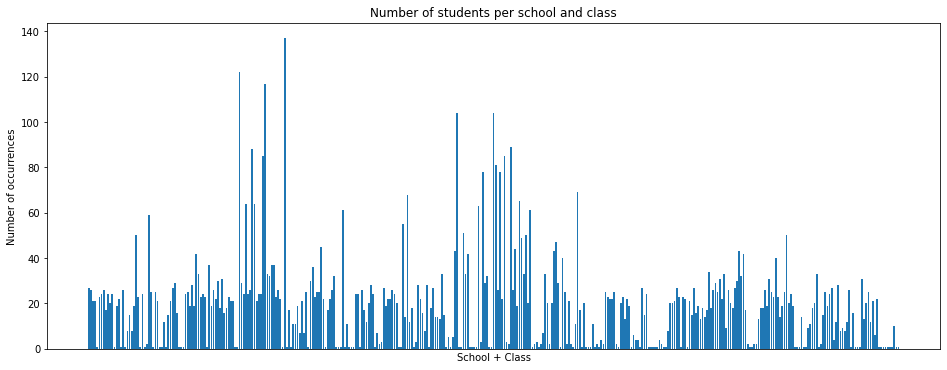

Number of distinct values: 377
Mean: 19.77
Median: 19.00
Standard Deviation: 20.31


In [68]:
data = grouped_df['Anon Student Id']
plot_bar(data, title='Number of students per school and class', xlabel='School + Class', show_xticks=False)

print_statistics(data)

The distribution of students between schools follow the same structure of the number of interactions, with a higher standard deviation and a big difference between the values of mean and median.

The number of students per class is well distributed with a few outiliers.

# Predictive model

At this part we tried to create a model that show us the best way to use the tutoring system to get the most of it.

We tried to predict when the students have a higher probability to input a right answer after receiving some hints.

Some algorithms used were:
- TODO: fill this part with the algorithms used

## Preparing the dataset for the model

Here we made some changes at the data to become an input to the machine learning models.

Only the CORRECT and INCORRECT outputs were considered at this analysis, because we considered that the HINT output could be considered as as intermediate level and its values were already used by the *Last Help Level* column.

We created a sample of the data to be easier to work with it and to have a less resource consumption.

In [76]:
ml_columns = ['Duration (sec)', 'Problem Name', 'Step Name', 'Attempt At Step', 'Outcome', 'Last Help Level']

### I used the parameter replace=True to get the bootstrapping effect
### https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
df_ml = df_cleaned[df_cleaned['Outcome'].isin(['CORRECT', 'INCORRECT'])][ml_columns].sample(n=N_SAMPLES, replace=True, ignore_index=True, weights='Outcome', random_state=SEED)

TypeError: '<' not supported between instances of 'str' and 'int'

In [74]:
df_ml['Outcome'].value_counts()

CORRECT      5964
INCORRECT    4036
Name: Outcome, dtype: int64